# 10.7 Sequence-to-Sequence Learning for Machine Translation
In this section, we will demonstrate the application of an encoder–decoder architecture, where both the encoder and decoder are implemented as RNNs, to the task of machine translation. Here, the encoder RNN will take a variable-length sequence as input and transform it into a fixed-shape hidden state. Later, in Chapter 11, we will introduce attention mechanisms, which allow us to access encoded inputs without having to compress the entire input into a single fixed-length representation.

Here, the encoder RNN will take a variable-length sequence as input and transform it into a fixed-shape hidden state. Later, in Chapter 11, we will introduce attention mechanisms, which allow us to access encoded inputs without having to compress the entire input into a single fixed-length representation.

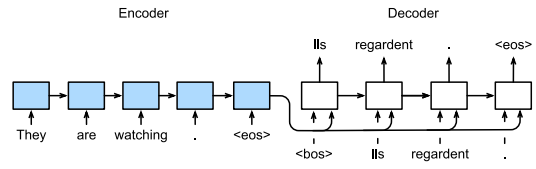

In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 10.7.1 Teacher Forcing

- **Teacher Forcing** is a technique used in **Encoder-Decoder architectures**, especially in sequence-to-sequence tasks.
- It improves training accuracy by using the **actual target sequence (ground truth)** as the input for the next time step instead of the model's prediction.
- In an **Encoder-Decoder**:
  - **Encoder**: Processes the input sequence and generates a fixed-size context vector.
  - **Decoder**: Generates the output sequence, usually using the previous time step's output as input for the next step.
- **How Teacher Forcing works**: During training, the decoder receives the **ground truth** as the next input, rather than the model's predicted output.
- **Advantages**:
  - Faster and more stable training.
  - Prevents cascading errors during training.
  - Useful in early training stages when the model's predictions are inaccurate.
- **Drawbacks**:
  - During inference, the model must use its predictions instead of the ground truth, potentially leading to performance differences.
- **Mitigation**: Techniques like **Scheduled Sampling** gradually introduce model predictions during training to prepare the model for inference.

## 10.7.2 Encoder

In [2]:
def init_seq2seq(module): #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [3]:
class Seq2SeqEncoder(d2l.Encoder): #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
    dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)
        
    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)

In [5]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

## 10.7.3 Decoder

Goal of decoder: assigning a predicted probability to each possible token occuring at step $y_{t' + 1}$ conditioned upon the previous tokens in the target $y_1, ..., y_{t'}$ and the context variable $\mathbf{c}$, i.e., $P(y_{t'+1}|y_1, y_2, ..., y_{t'}, \mathbf{c})$ and $y_1, y_2, ..., y_{t'}$ are compressed as hidden variables.

In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
        num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [7]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/home/solee/miniconda3/envs/dive2dl/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


The layers in the above RNN encoder-decoder model are summarized as follow:

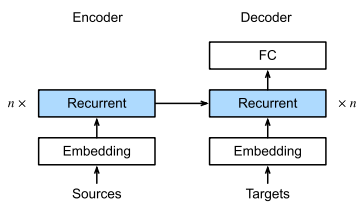

## 10.7.4 Encoder-Decoder for Sequence-to-Sequence Learning

In [8]:
class Seq2Seq(d2l.EncoderDecoder): #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## 10.7.5 Loss Function with Masking

At each time step, the decoder predicts a probability distribution for the output tokens. As with language modeling, we can apply softmax to obtain the distribution and calculate the cross-entropy loss for optimization. Recall from Section 10.5 that the special padding tokens are appended to the end of sequences and so sequences of varying lengths can be efficiently loaded in minibatches of the same shape. However, prediction of padding tokens should be excluded from loss calculations. To this end, we can mask irrelevant entries with zero values so that multiplication of any irrelevant prediction with zero equates to zero.

In [9]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

## 10.7.6 Training

In [10]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
lr=0.005)

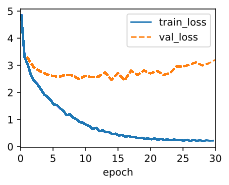

In [11]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.7.7 Prediction

In [12]:
@d2l.add_to_class(d2l.EncoderDecoder) #@save
def predict_step(self, batch, device, num_steps,
    save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

## 10.7.8 Evaluation of Prediction Sequences

- **BLEU (Bilingual Evaluation Understudy)**: A metric to evaluate the quality of predicted sequences by comparing them with target sequences (ground truth).
- Originally designed for machine translation, but now widely used for evaluating the quality of output sequences in various applications.
- **Key concept**: BLEU checks whether n-grams in the predicted sequence appear in the target sequence.

- **n-gram precision (\( p_n \))**: Defined as the ratio of matched n-grams between the predicted and target sequences to the total n-grams in the predicted sequence.
  - Example:
    - Target sequence: A, B, C, D, E, F
    - Predicted sequence: A, B, B, C, D
    - \( p_1 = 4/5 \), \( p_2 = 3/4 \), \( p_3 = 1/3 \), \( p_4 = 0 \)

- **Length variables**:
  - \( \text{len}_{\text{label}} \): Number of tokens in the target sequence.
  - \( \text{len}_{\text{pred}} \): Number of tokens in the predicted sequence.

- **BLEU formula**:
  \[
  \text{BLEU} = \exp \left( \min \left( 0, 1 - \frac{\text{len}_{\text{label}}}{\text{len}_{\text{pred}}} \right) \right) \cdot \prod_{n=1}^{k} p_n^{\frac{1}{n}}
  \]
  - **k** is the longest n-gram used for matching.

- **BLEU Score 1**: When the predicted sequence matches exactly with the target sequence, BLEU = 1.
  
- **Longer n-grams**: Matching longer n-grams is harder, so BLEU assigns more weight to cases where longer n-grams have high precision.
  - As \( n \) grows, \( p_n^{1/n} \) decreases, penalizing models with shorter predicted sequences.

- **Brevity Penalty**: Shorter predicted sequences are penalized to avoid high BLEU scores for short but imprecise predictions.
  - Example: 
    - Target: A, B, C, D, E, F
    - Prediction: A, B
    - Even though \( p_1 = p_2 = 1 \), the penalty factor \( \exp(1 - 6/2) \approx 0.14 \), reducing the BLEU score.

In [13]:
def bleu(pred_seq, label_seq, k): #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [14]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
        f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['sois', 'calme', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
